In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal
import statsmodels.api as sa 
import scikit_posthocs as sp  # sp.posthoc_dunn() для непараметрического аналога anova 
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import chi2_contingency, chi2 
from scipy.stats import kstest
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
import plotly.express as px
from urllib.parse import urlencode
import requests

#### Кейс №1 - Приложение знакомств

Вы работаете аналитиком в приложении для онлайн-знакомств. Механика приложения следующая: пользователи видят в приложении анкеты друг друга и могут ставить друг другу лайки или дизлайки. Если пользователи поставили друг другу лайк – это называется мэтч, и у пользователей появляется возможность познакомиться.

Команда приложения разработала новый алгоритм для поиска наиболее подходящих анкет. Для проверки работы алгоритма был проведен АБ-тест. Все пользователи были разделены на две группы. Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет.

Ваша задача – оценить, правда ли, что новый алгоритм улучшил качество сервиса. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

В данных находится выгрузка логов взаимодействия пользователей друг с другом. Для каждой пары пользователей указано, из какой они группы АБ-теста и случился ли у них мэтч.

Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему поиска анкет на всех пользователей.

In [2]:
from download import download_yd
users=download_yd('https://disk.yandex.ru/d/txn7q-CE2zSaPg', ',')

In [3]:
users.isna().sum()

user_id_1    0
user_id_2    0
group        0
is_match     0
dtype: int64

Для начала создадим два отдельных датафрейма старого и нового дизайна приложения и посмотрим на размеры.

In [4]:
old_alg = users.query("group==0")
new_alg = users.query("group==1")

In [5]:
old_alg

,user_id_1,user_id_2,group,is_match
2,423,677,0,0
4,969,155,0,1
5,227,162,0,0
8,223,295,0,0
10,825,388,0,0
...,...,...,...,...
14502,535,545,0,0
14503,128,268,0,0
14505,544,600,0,0
14506,903,505,0,0


In [6]:
new_alg

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
3,658,165,1,1
6,435,16,1,0
7,602,327,1,0
...,...,...,...,...
14508,527,647,1,0
14510,455,770,1,0
14511,260,6,1,1
14512,885,812,1,1


Посмотрим сколько уникальных значений пользователей в каждом датафрейме.

In [7]:
new_alg.user_id_1.nunique()

499

In [8]:
new_alg.user_id_2.nunique()

499

In [9]:
old_alg.user_id_1.nunique()

501

In [10]:
old_alg.user_id_2.nunique()

501

Как видно выше у нас почти одинаковое количество пользователей, в приложениях со старым и новых алгоритмах. Однако размер датафрема для приложения с новым дизайном больше, чем со старым. Если наш эксперимент проводился одинаковое время, то судя только по размеру датафреймов видно, что пользователи гораздо больше времени проводят в приложении с новым дизайном. Дальше посмотрим на процент заматчившихся пар в приложениях.

C:\Users\mirza\AppData\Local\Temp\ipykernel_20348\120789725.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['нет мэтча', 'метча'])


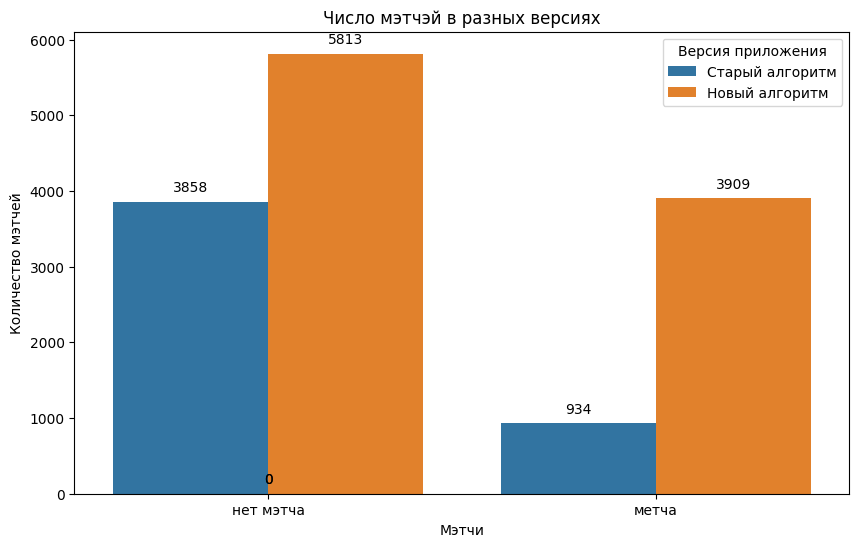

In [12]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=users, x="is_match", hue="group")
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.legend(title='Версия приложения', labels=['Старый алгоритм', 'Новый алгоритм'], loc='upper right')
plt.title('Число мэтчэй в разных версиях')
plt.xlabel('Мэтчи')
plt.ylabel('Количество мэтчей')
ax.set_xticklabels(['нет мэтча', 'метча'])
for text in ax.texts:
    text.set_color('black')
#plt.savefig('Число мэтчэй в разных версиях.jpeg')
plt.show()


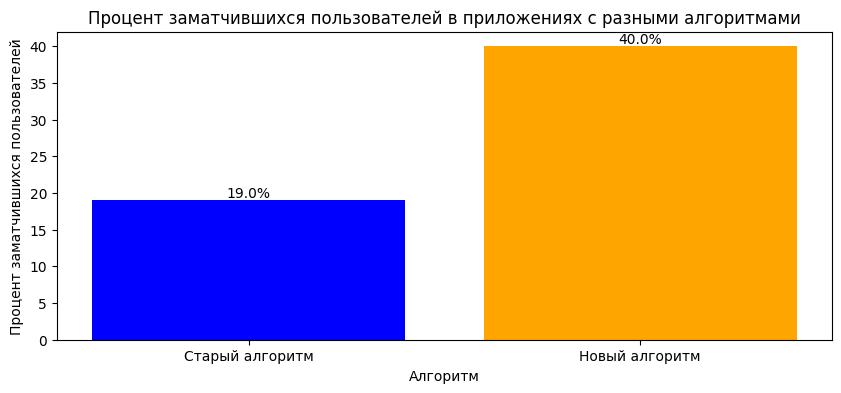

In [16]:
old_alg_match = np.round(old_alg.is_match.sum() / old_alg.is_match.count() * 100)
new_alg_match = np.round(new_alg.is_match.sum() / new_alg.is_match.count() * 100)


labels = ['Старый алгоритм', 'Новый алгоритм']
percentages = [old_alg_match, new_alg_match]

plt.figure(figsize=(10, 4))
plt.bar(labels, percentages, color=['blue', 'orange'])

# Добавляем проценты к столбцам
for i, percentage in enumerate(percentages):
    plt.text(i, percentage, f'{percentage}%', ha='center', va='bottom', color='black')

plt.xlabel('Алгоритм')
plt.ylabel('Процент заматчившихся пользователей')
plt.title('Процент заматчившихся пользователей в приложениях с разными алгоритмами')
#plt.savefig('Процент заматчившихся пользователей.jpeg')
plt.show()


Для того чтобы оценить какое приложение лучше, я решил отталкиваться от количества мэтчей.

Как я понял у нас среднее количество мэтчей у user_id_1 и user_id_2 должно быть одинаковым. потому что мэтч означает, что образовалась пара. Соответственно количество пар должно быть одинаковым. Сейчас я посчитаю среднее количество мэтчей. Если они равны, то тогда возьму среднее количество мэтчей у приложений разных версий и проведу тест. Какой, тест решу дальше.

In [17]:
mean_match_new_alg_user_1 = new_alg.groupby('user_id_1',as_index=False).is_match.mean().is_match.mean()
mean_match_new_alg_user_2 =new_alg.groupby('user_id_2',as_index=False).is_match.mean().is_match.mean()
mean_match_old_alg_user_1 = old_alg.groupby('user_id_1',as_index=False).is_match.mean().is_match.mean()
mean_match_old_alg_user_2 = old_alg.groupby('user_id_2',as_index=False).is_match.mean().is_match.mean()
print(f'''Среднее количество мэтчей для разных версий равно:
- {np.round(mean_match_new_alg_user_1,2)} user_1 с новым дизайном;
- {np.round(mean_match_new_alg_user_2,2)} user_2 с новым дизайном;
- {np.round(mean_match_old_alg_user_1,2)} user_1 с новым дизайном;
- {np.round(mean_match_old_alg_user_2,2)} user_2 с новым дизайном.''')

Среднее количество мэтчей для разных версий равно:
- 0.4 user_1 с новым дизайном;
- 0.4 user_2 с новым дизайном;
- 0.19 user_1 с новым дизайном;
- 0.19 user_2 с новым дизайном.


Как видно выше наша теория подтвердилась. Причем среднее количество мэтчей в приложении с новым алгоритмом увеличилось. 
Нулевая гипотеза - среднее количество мэтчей в приложениях со старым и новым алгоритном статистически значимо не отличается.
Альтернативная гипотеза - среднее количество мэтчей в приложениях со старым и новым алгоритном статистически значимо отличается.

In [18]:
mean_match_new_alg = new_alg.groupby('user_id_1',as_index=False).is_match.mean()
mean_match_old_alg = old_alg.groupby('user_id_1',as_index=False).is_match.mean()

Посмотрим на нормальность распределения и на гомогенность дисперсий.

Text(0, 0.5, 'Частота')

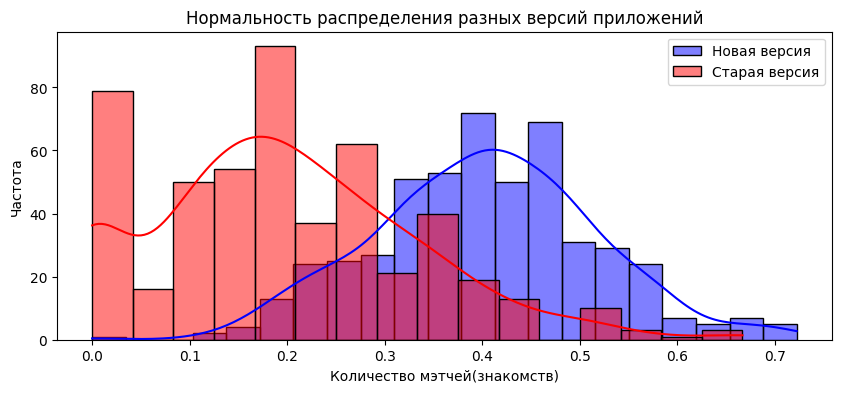

In [21]:
plt.figure(figsize=(10, 4))
sns.histplot(data=mean_match_new_alg, x='is_match', kde=True,color='blue', label='Новая версия')
sns.histplot(data=mean_match_old_alg, x='is_match', kde=True,color='red', label='Старая версия')
plt.legend()
plt.title('Нормальность распределения разных версий приложений')
plt.xlabel('Количество мэтчей(знакомств)')
plt.ylabel('Частота')
#plt.savefig('Нормальность распределения разных версий приложений.jpeg')

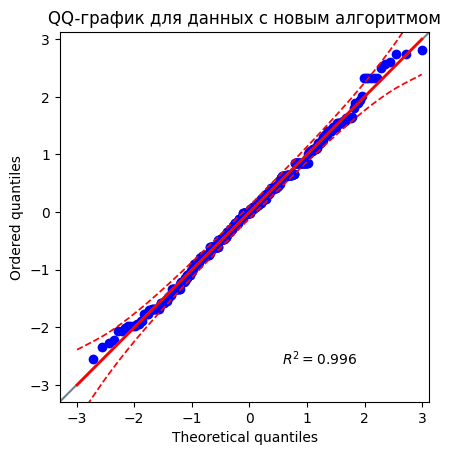

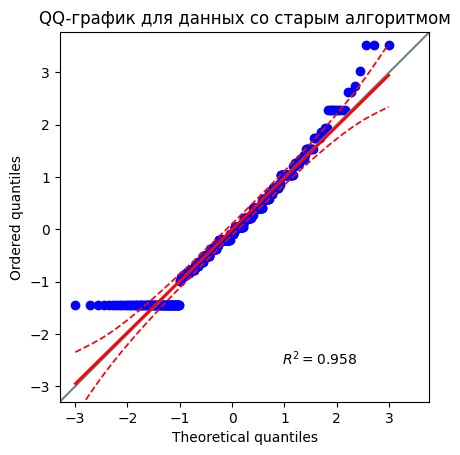

In [22]:
# Создание QQ-графика для данных mean_match_new_alg
import pingouin as pg
pg.qqplot(mean_match_new_alg['is_match'])
plt.title('QQ-график для данных с новым алгоритмом')
plt.show()

# Создание QQ-графика для данных mean_match_old_alg
pg.qqplot(mean_match_old_alg['is_match'])
plt.title('QQ-график для данных со старым алгоритмом')
plt.show()

In [26]:
data = pd.concat([mean_match_old_alg['is_match'], mean_match_new_alg['is_match']], axis=1)
data.columns = ['Старый алгоритм', 'Новый алгоритм']

C:\Users\mirza\AppData\Local\Temp\ipykernel_20348\3072969954.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Алгоритм', y='is_match', data=data, palette='Set1')


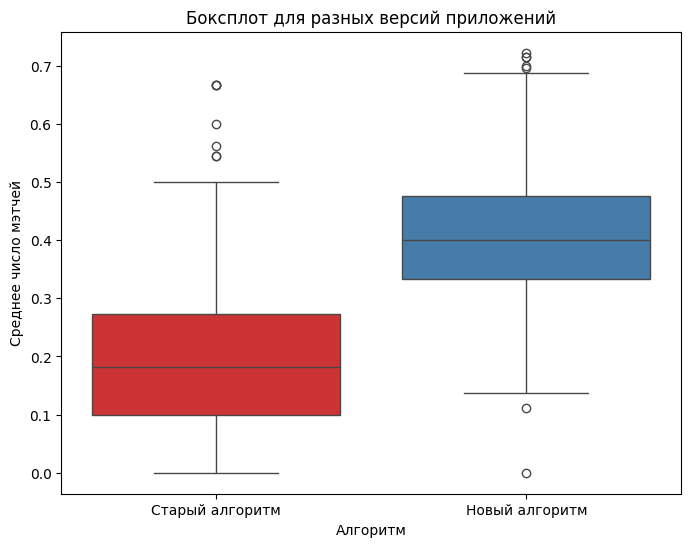

In [27]:
# Преобразуем данные в "длинный" формат для построения boxplot
data = data.melt(var_name='Алгоритм', value_name='is_match')

# Строим boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Алгоритм', y='is_match', data=data, palette='Set1')
plt.title('Боксплот для разных версий приложений')
plt.ylabel('Среднее число мэтчей')
plt.show()

In [28]:
#Проведение теста Левена на гомогенность дисперсий
from scipy.stats import levene
statistic, p_value = levene(mean_match_new_alg['is_match'], mean_match_old_alg['is_match'])
print("Статистика теста Левена:", statistic)
print("p-значение:", p_value)

Статистика теста Левена: 10.36747817150431
p-значение: 0.0013239471747665337


In [29]:
# Проведение теста Колмогорова-Смирнова на нормальность распределения данных
from scipy.stats import ks_2samp
statistic, p_value = ks_2samp(mean_match_new_alg['is_match'], mean_match_old_alg['is_match'])
# Вывод результатов теста
print("Статистика теста Колмогорова-Смирнова:", statistic)
print("p-значение:", p_value)

Статистика теста Колмогорова-Смирнова: 0.6279745118980475
p-значение: 7.224239751089469e-93


Как видно выше данные не имеют норамльного распределения, а также дисперсии не гомогенны. Но размеры выборок достаточно большие. Поэтому предлагаю использовать t-test.

In [30]:
from scipy.stats import ttest_ind
print(ttest_ind(mean_match_new_alg['is_match'],mean_match_old_alg['is_match']), '- T-test.')

TtestResult(statistic=26.418503752817923, pvalue=4.842755754030708e-117, df=998.0) - T-test.


Как видно выше, данные действительно статистически значимо различаются. Исходя из этого принимаем альтернативную гипотезу.

### Вывод 
Приложение для знакомств с новым алгоритмом повысило активность пользователей. Количество мэтчей в процентном соотношении увеличилось. Следовательно у нас достаточно оснований, чтобы включить новую систему поиска анкет для всех пользователей. Вероятность того, что новый алгоритм улучшит работу приложения довольно высокая.